In [10]:
# Import the pandas library.
import pandas as pd
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Define the URL where the dataset is stored.
# url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'

# Use pandas to read the CSV file from the URL into a DataFrame.
# A DataFrame is a 2-dimensional labeled data structure, like a spreadsheet.
print("Loading dataset from the source...")
df = pd.read_csv(url)
print("Dataset loaded successfully.")

# --- Initial Exploration ---

# 1. Display the first 5 rows of the DataFrame
# This gives us a quick first look at the columns and the data they contain.
print("\n--- First 5 Rows of the Dataset ---")
print(df.head())

# 2. Get a concise summary of the DataFrame
# .info() is great for checking data types (like object, int64) and spotting missing values.
print("\n--- Dataset Information ---")
df.info()

# 3. Generate descriptive statistics for numerical columns
# .describe() provides stats like mean, standard deviation, min, and max for number-based columns.
# This helps us understand the distribution and scale of our numerical data.
print("\n--- Descriptive Statistics for Numerical Columns ---")
print(df.describe())

# 4. Save the DataFrame to a CSV file
# df.to_csv('telco_customer_churn.csv', index=False)

Loading dataset from the source...
Dataset loaded successfully.

--- First 5 Rows of the Dataset ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic   

--- Analysis of Target Variable (Churn) ---


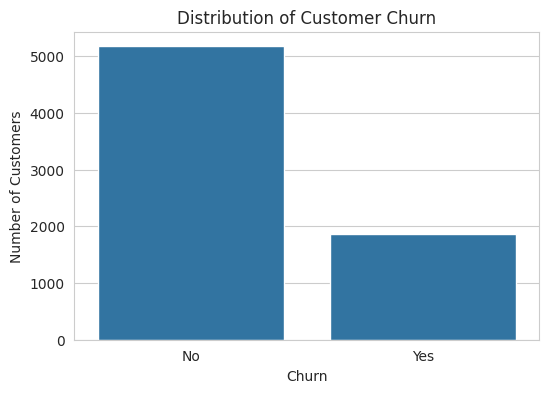


--- Analysis of Numerical Features vs. Churn ---


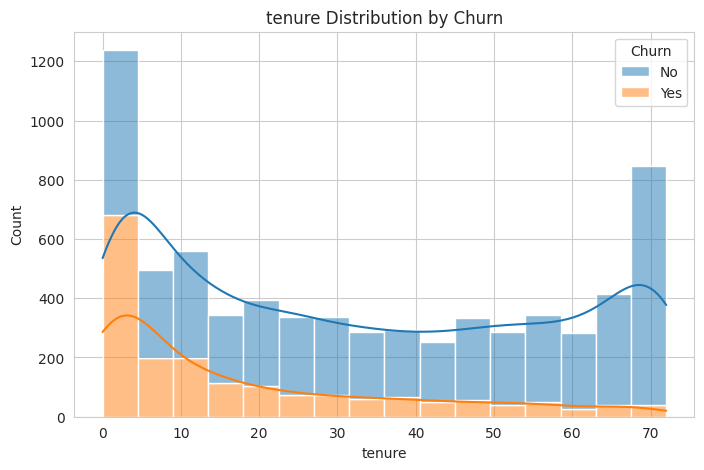

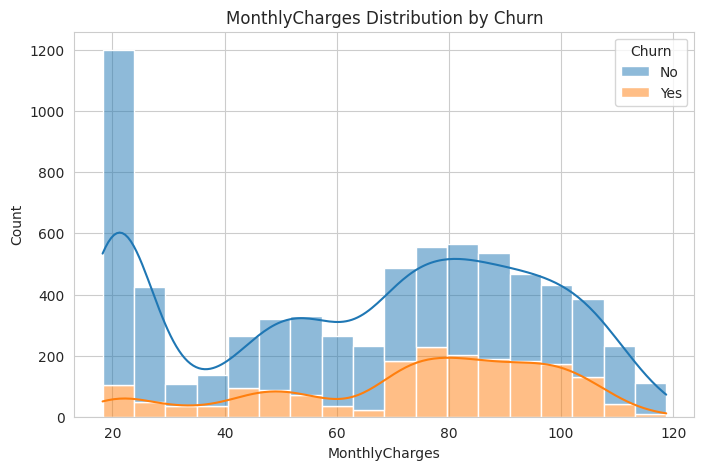


--- Analysis of Categorical Features vs. Churn ---


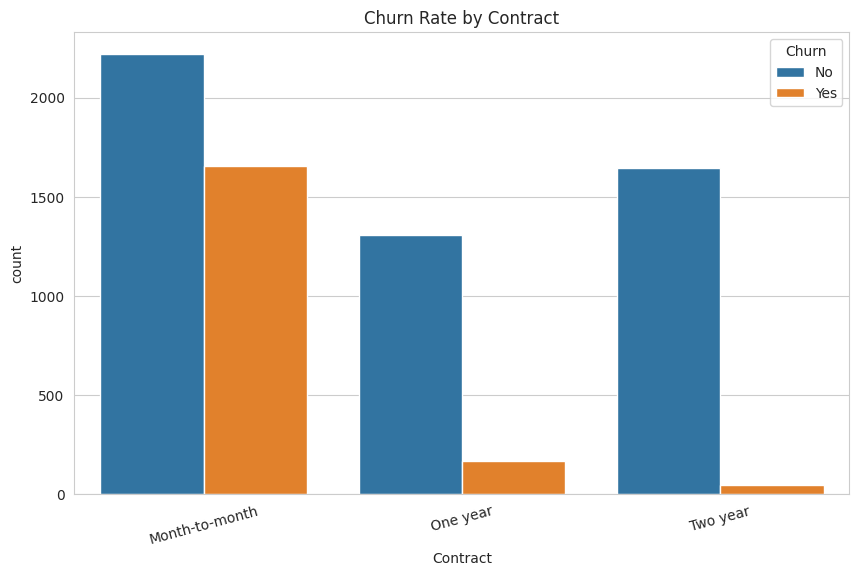

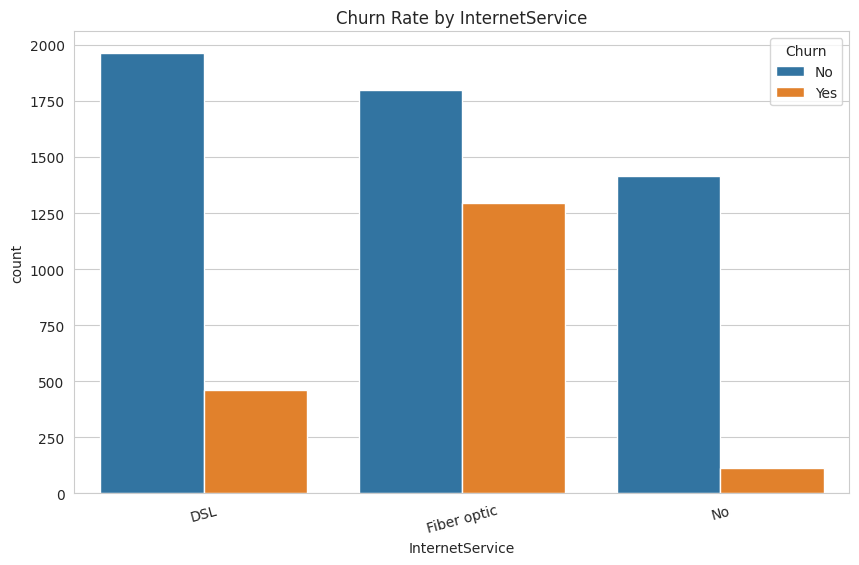

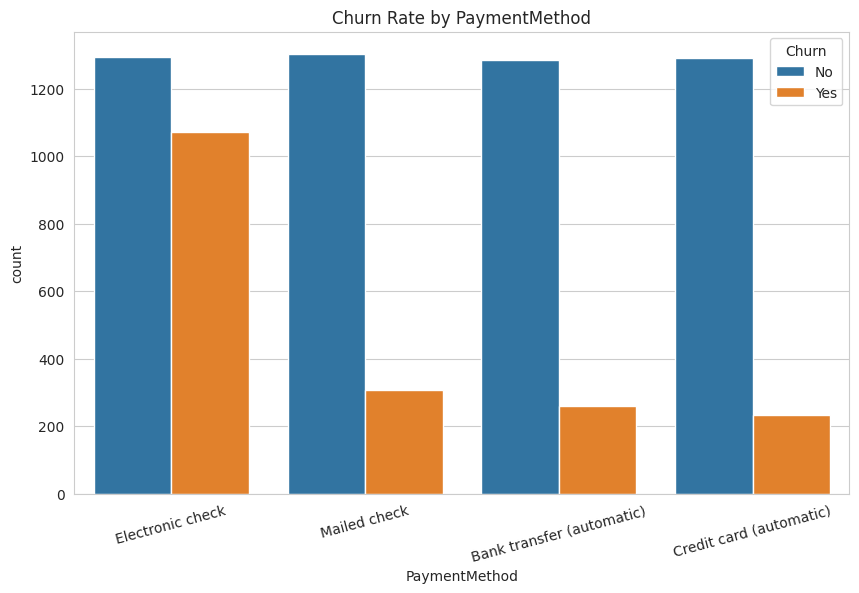

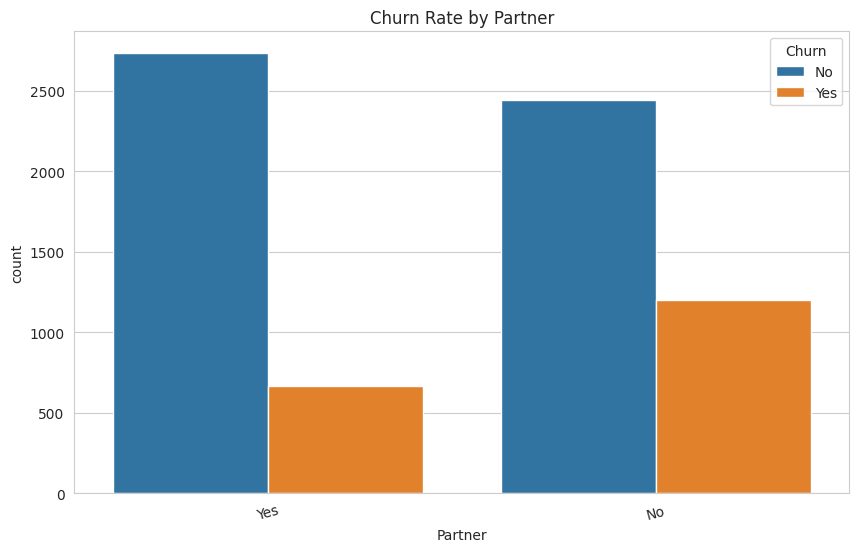

In [11]:
# Set a style for the plots to make them look nicer
sns.set_style('whitegrid')

# --- 1. Analyze the Target Variable: Churn ---
# We want to see the distribution of customers who churned vs. those who did not.
print("--- Analysis of Target Variable (Churn) ---")
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Customer Churn')
plt.xlabel('Churn')
plt.ylabel('Number of Customers')
plt.show()

# --- 2. Analyze Numerical Features vs. Churn ---
# Let's see how tenure, monthly charges, and total charges differ for churning customers.
print("\n--- Analysis of Numerical Features vs. Churn ---")
numerical_features = ['tenure', 'MonthlyCharges'] # TotalCharges will be handled later as it has issues
for col in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=col, hue='Churn', multiple='stack', kde=True)
    plt.title(f'{col} Distribution by Churn')
    plt.show()

# --- 3. Analyze Key Categorical Features vs. Churn ---
# This helps us see if certain services or contract types lead to more churn.
print("\n--- Analysis of Categorical Features vs. Churn ---")
categorical_features = ['Contract', 'InternetService', 'PaymentMethod', 'Partner']
for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'Churn Rate by {col}')
    plt.xticks(rotation=15) # Rotate labels slightly if they overlap
    plt.show()

In [12]:
print("--- Starting Data Preprocessing ---")

# Make a copy to keep the original dataframe intact

df_processed = df.copy()

# --- 1. Handle Missing Values in 'TotalCharges' ---
# 'TotalCharges' is an object type because some values are empty strings ' '.
# Let's convert them to a numeric type, coercing errors to NaN (Not a Number).
df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')

# Now, we fill the resulting NaN values. A good strategy is to use the median.
median_total_charges = df_processed['TotalCharges'].median()
df_processed['TotalCharges'].fillna(median_total_charges, inplace=True)
print("Handled missing values in 'TotalCharges'.")

# --- 2. Encode Categorical Features ---
# We'll use one-hot encoding to convert categorical columns into numerical ones.
# 'customerID' is just an identifier, so we'll drop it.
# 'Churn' is our target variable, so we don't encode it.
df_processed = pd.get_dummies(df_processed, columns=['gender', 'Partner', 'Dependents', 
                                                     'PhoneService', 'MultipleLines', 
                                                     'InternetService', 'OnlineSecurity', 
                                                     'OnlineBackup', 'DeviceProtection', 
                                                     'TechSupport', 'StreamingTV', 
                                                     'StreamingMovies', 'Contract', 
                                                     'PaperlessBilling', 'PaymentMethod'],
                              drop_first=True) # drop_first=True helps avoid multicollinearity

# Convert the Churn column to 0s and 1s
df_processed['Churn'] = df_processed['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
print("Encoded categorical features and target variable.")

# --- 3. Split Data into Features (X) and Target (y) ---
X = df_processed.drop(['customerID', 'Churn'], axis=1)
y = df_processed['Churn']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# --- 4. Scale Numerical Features ---
# We scale features like 'tenure', 'MonthlyCharges', and 'TotalCharges'.
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()

# Fit the scaler ONLY on the training data
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Transform the test data using the SAME scaler fitted on the training data
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
print("Numerical features have been scaled.")

# Display the first few rows of the processed training data
print("\n--- Processed Training Data (First 5 Rows) ---")
print(X_train.head())

--- Starting Data Preprocessing ---
Handled missing values in 'TotalCharges'.
Encoded categorical features and target variable.
Data split into training and testing sets.
X_train shape: (5634, 30)
X_test shape: (1409, 30)
Numerical features have been scaled.

--- Processed Training Data (First 5 Rows) ---
      SeniorCitizen    tenure  MonthlyCharges  TotalCharges  gender_Male  \
3738              0  0.102371       -0.521976     -0.263289         True   
3151              0 -0.711743        0.337478     -0.504814         True   
4860              0 -0.793155       -0.809013     -0.751213         True   
3867              0 -0.263980        0.284384     -0.173699        False   
3810              0 -1.281624       -0.676279     -0.990851         True   

      Partner_Yes  Dependents_Yes  PhoneService_Yes  \
3738        False           False             False   
3151         True            True              True   
4860         True            True             False   
3867         Tru

/tmp/ipykernel_111718/2194206940.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['TotalCharges'].fillna(median_total_charges, inplace=True)


--- Training Logistic Regression Model ---

--- Evaluating Logistic Regression Model ---
Accuracy: 0.8055

Classification Report:
               precision    recall  f1-score   support

Did Not Churn       0.85      0.89      0.87      1035
      Churned       0.66      0.56      0.60       374

     accuracy                           0.81      1409
    macro avg       0.75      0.73      0.74      1409
 weighted avg       0.80      0.81      0.80      1409


Confusion Matrix:


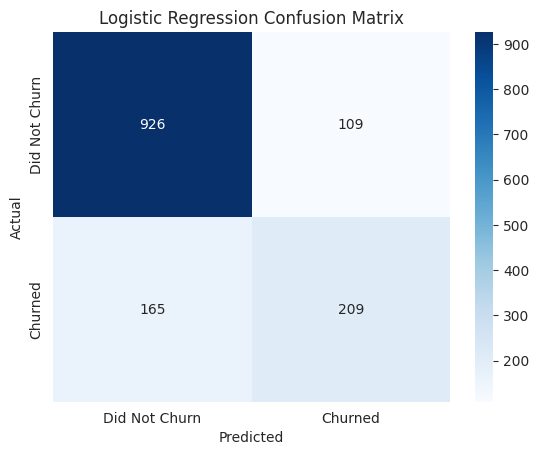



--- Training Random Forest Model ---

--- Evaluating Random Forest Model ---
Accuracy: 0.7857

Classification Report:
               precision    recall  f1-score   support

Did Not Churn       0.83      0.89      0.86      1035
      Churned       0.62      0.49      0.55       374

     accuracy                           0.79      1409
    macro avg       0.73      0.69      0.70      1409
 weighted avg       0.77      0.79      0.78      1409


Confusion Matrix:


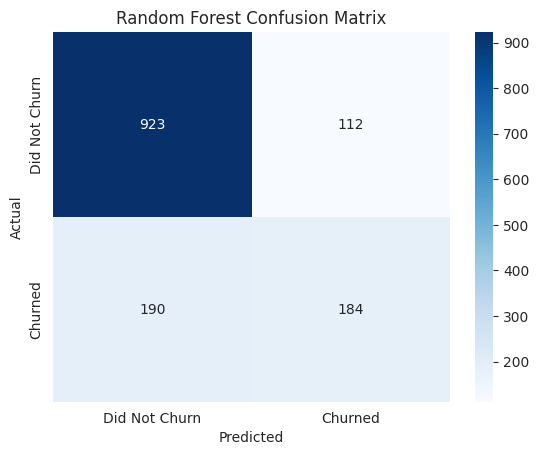

In [13]:
# --- 1. Train and Evaluate a Baseline Model: Logistic Regression ---
print("--- Training Logistic Regression Model ---")

# Initialize the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on the training data
log_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred_log_reg = log_reg.predict(X_test)

print("\n--- Evaluating Logistic Regression Model ---")
# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_log_reg)
print(f"Accuracy: {accuracy_lr:.4f}")

# Display the classification report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_reg, target_names=['Did Not Churn', 'Churned']))

# Display the confusion matrix
print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Did Not Churn', 'Churned'], yticklabels=['Did Not Churn', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# --- 2. Train and Evaluate a More Complex Model: Random Forest ---
print("\n\n--- Training Random Forest Model ---")

# Initialize the model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_clf.predict(X_test)

print("\n--- Evaluating Random Forest Model ---")
# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}")

# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Did Not Churn', 'Churned']))

# Display the confusion matrix
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Did Not Churn', 'Churned'], yticklabels=['Did Not Churn', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()